<a href="https://colab.research.google.com/github/aevangeline/forensics/blob/master/10701_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Aurelia and Caroline - 10701

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist/cuda/10.0


In [0]:
from zipfile import ZipFile
import pathlib
from urllib.request import urlretrieve
import os
from os import remove
import os.path
import numpy as np
import pandas as pd
import shutil as sh
import torch
import glob
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
from random import random
import math

In [0]:
FID_DIRECTORY = pathlib.Path("FID-300")
FID_LABELS = FID_DIRECTORY / "label_table.csv"
FID_SOURCE_URL = "https://fid.dmi.unibas.ch/FID-300.zip"
TRAIN_DIR = "FID-300/tracks_cropped/"
NUM_EPOCHS = 10
db_folder = pathlib.Path("test/")

In [0]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, image_dir, repeat = 32):
        self.images_dir = pathlib.Path(image_dir)
        self.images = list(glob.iglob(str(self.images_dir/"*.jpg")))
        self.batch_size = batch_size 
        self.i = 0
        self.repeat = math.ceil(repeat/batch_size) * batch_size
        self.reps = 0
        

    def __iter__(self):
        self.i = 0
        self.reps = 0
        self.n = len(self.files)
        return self

    def __increment(self):
      self.reps += 1
      if self.reps >= self.repeat:
        self.reps = 0
        self.i += 1

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
          if self.i >= len(self.images):
            raise StopIteration
            break 
          fname = pathlib.Path(self.images[self.i])
          label = np.array(fname.stem, dtype = np.uint8)
          f = open(fname, 'rb')
          batch.append(np.frombuffer(f.read(), dtype = np.uint8))
          labels.append(label)
          self.__increment()        
        return (batch, labels)

    next = __next__

In [0]:
class AugmentationPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id,
                 examples_per_image = 1000, folder = db_folder,
                 pipelined = True, exec_async = True):
        super(AugmentationPipeline, self).__init__(batch_size, num_threads,
                                                   device_id, seed = 12,
                                                   exec_pipelined=pipelined,
                                                   exec_async=exec_async)
        self.data_iterator = ExternalInputIterator(batch_size,
                                                   folder,
                                                   examples_per_image)
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()
        self.decode = ops.ImageDecoderRandomCrop(device = "mixed", output_type = types.GRAY,
            random_aspect_ratio=[0.8, 1.25],
            random_area=[0.3, 1.0],
            num_attempts=100)
        self.augmentations = {}
        # input is sampled randomly for output pixel's neighbourhood
        #self.augmentations["jitter"] = (0.3, ops.Jitter(device = "gpu"))
        # transforms sampling coordinates to produce wavy patterns
        #self.augmentations["water"] = (0.2, ops.Water(device = "gpu"))
        # applies fisheye distortion
        #self.augmentations["sphere"] = (0.3, ops.Sphere(device = "gpu"))
        # rotates the image, enlarging the canvas
        self.rotation_rng = ops.Uniform(range=(-180.00, 180.00))
        self.rotate = ops.Rotate(device = "gpu",
                                 interp_type = types.INTERP_LINEAR,
                                 fill_value = 0)
        # param resizes the image so that the shorter edge is exactly 400px long
        self.resize = ops.Resize(device = "gpu", resize_x = 300, resize_y = 300)
        # param flips the image
        self.flip_rng = ops.CoinFlip()
        self.flip = ops.Flip(device = "gpu")
        self.bri_con_rng = ops.Uniform(range = (.5, 2))
        self.saturation_rng = ops.Uniform(range = (.2, 1))
        self.color_twist = ops.ColorTwist(device = "gpu")
        self.iter = 0

    def define_graph(self):
        self.jpegs = self.input()
        self.labels = self.input_label()
        output_labels = []
        images = self.decode(self.jpegs).gpu()
        transformed = images
        for thresh, op in self.augmentations.values():
          if random() < thresh:
            transformed = op(images)
        #transformed = self.flip(transformed,
        #                        vertical = self.flip_rng(),
        #                        horizontal = self.flip_rng())
        #transformed = self.rotate(transformed, angle = self.rotation_rng())
        #transformed = self.color_twist(transformed, brightness=self.bri_con_rng(),
        #                                contrast=self.bri_con_rng(),
        #                                saturation=self.saturation_rng())
        transformed = self.resize(transformed)
        return (transformed, self.labels)


    def iter_setup(self):
      # the external data iterator is consumed here and fed as input to Pipeline
      images, labels = self.data_iterator.next()
      self.feed_input(self.jpegs, images)
      self.feed_input(self.labels, labels)
      


In [0]:


batch_size = 32

pipe = AugmentationPipeline(batch_size=32, examples_per_image= 1,
                            num_threads=4, device_id = 0)
pipe.build()



32


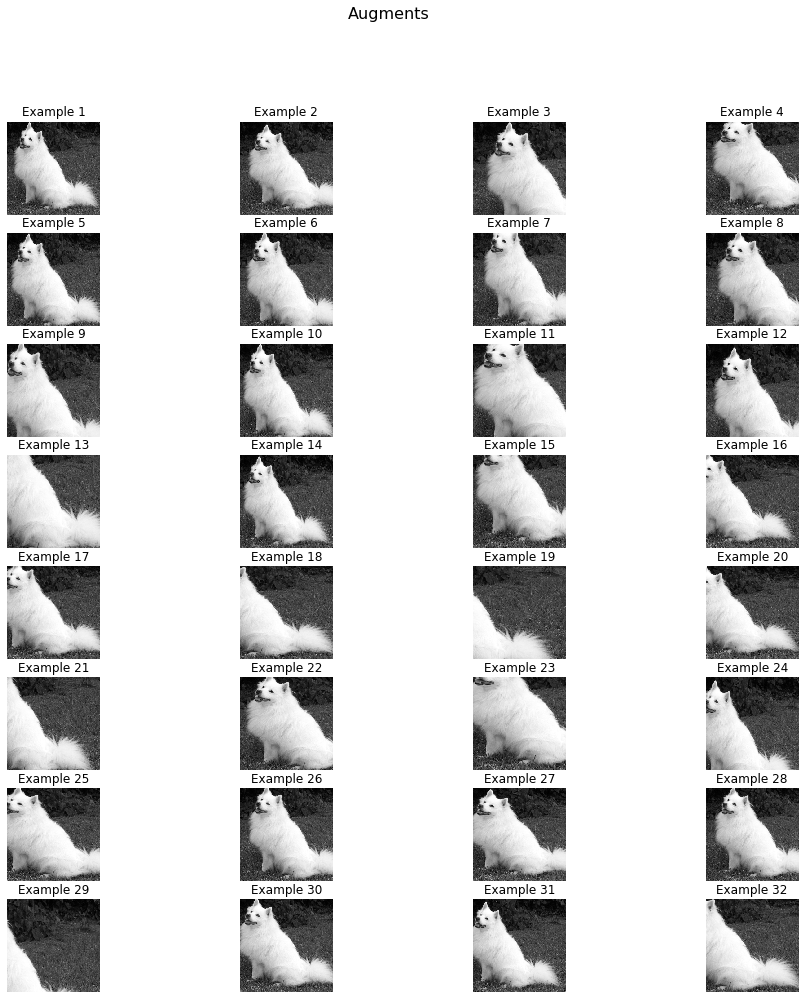

In [121]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,16))
plt.suptitle("Augments", fontsize=16)
columns = 4
display = []

images, labels = pipe.run()
imgs = images.as_cpu()

for idx in range(len(imgs)):
  img = imgs.at(idx)
  img = np.reshape(img, img.shape[0:2])
  display.append(img)

rows = int(math.ceil(len(imgs) / columns))
gs = gridspec.GridSpec(rows, columns)

print(len(display))
for count, img in enumerate(display):
  plt.subplot(gs[count])
  plt.axis("off")
  plt.title("Example {}".format(count + 1))
  plt.imshow(img, cmap="gray")